In [4]:
%pip install -q matplotlib
%pip install -q networkx
%pip install -q pandas
%pip install -q torchinfo

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import copy
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import poptorch
import random
import torch
import torch.nn as nn
import torch.nn.functional as F

from datetime import datetime
from lamah_dataset import LamaHDataset
from poptorch_geometric import FixedSizeDataLoader
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.transforms import AddSelfLoops, ToUndirected
from torch_geometric.utils import to_networkx
from torchinfo import summary
from tqdm import tqdm

In [2]:
# IPU paradigm demands that models return the loss as second output
class LossAppender(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x, y):
        return x, F.mse_loss(x, y)

    
class MLP(LossAppender):
    def __init__(self, window_size_hrs, num_hidden, hidden_size, residual):
        super().__init__()
        self.residual = residual
        self.layers = nn.ModuleList([nn.Linear(window_size_hrs, hidden_size) if i == 0 else
                                     nn.Linear(hidden_size, 1) if i == num_hidden else
                                     nn.Linear(hidden_size, hidden_size)
                                     for i in range(0, num_hidden + 1)])

    def forward(self, x, edge_index, y):
        x = F.relu(self.layers[0](x))
        for layer in self.layers[1:-1]:
            x = F.relu(layer(x)) + (x if self.residual else 0)
        x = self.layers[-1](x)

        return super().forward(x, y)
    

class GCN(LossAppender):
    def __init__(self, window_size_hrs, num_convs, hidden_size, residual, edge_weights):
        super().__init__()
        self.dense_in = nn.Linear(window_size_hrs, hidden_size)
        self.convs = nn.ModuleList([GCNConv(hidden_size, hidden_size, add_self_loops=False) for _ in range(num_convs)])
        self.dense_out = nn.Linear(hidden_size, 1)
        self.edge_weights = edge_weights
        self.residual = residual

    def forward(self, x, edge_index, y):
        num_graphs = edge_index.size(1) // len(self.edge_weights)
        edge_weights = self.edge_weights.clamp(min=1e-10).repeat(num_graphs).to(x.device)

        x = F.relu(self.dense_in(x))
        for conv in self.convs:
            h = conv(x, edge_index, edge_weights)
            x = F.relu(h) + (x if self.residual else 0)
        x = self.dense_out(x)

        return super().forward(x, y)


In [15]:
def ensure_reproducibility(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    
def get_edge_weights(weight_type, data):
    if weight_type == "disabled":
        return torch.zeros(data.num_edges)
    elif weight_type == "binary":
        return torch.ones(data.num_edges)
    elif weight_type == "dist_hdn":
        return data.edge_attr[:, 0]
    elif weight_type == "elev_diff":
        return data.edge_attr[:, 1]
    elif weight_type == "strm_slope":
        return data.edge_attr[:, 2]
    elif weight_type == "learned":
        return nn.Parameter(torch.ones(data.num_edges))
    else:
        raise ValueError("Invalid weight type given!")
    

def train_step(model, train_loader, optimizer, device, on_ipu):
    model.train()
    train_loss = 0
    pbar = tqdm(train_loader, desc="Training")
    for batch in pbar:
        if device != "IPU":
            batch = batch.to(device)
            optimizer.zero_grad()
        out, loss = model(batch.x, batch.edge_index, batch.y)
        if device != "IPU":
            loss.backward()
            optimizer.step()
        train_loss += loss.item() * batch.num_graphs / len(train_loader.dataset)
        pbar.set_postfix(train_loss=train_loss)
    return train_loss


def val_step(model, val_loader, device, on_ipu):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        pbar = tqdm(val_loader, desc="Validating")
        for batch in pbar:
            if device != "IPU":
                batch = batch.to(device)
            out, loss = model(batch.x, batch.edge_index, batch.y)
            val_loss += loss.item() * batch.num_graphs / len(val_loader.dataset)
            pbar.set_postfix(val_loss=val_loss)
    return val_loss


def train(model, train_dataset, val_dataset, hparams, on_ipu=False):
    train_loader = DataLoader(train_dataset, batch_size=hparams["training"]["batch_size"], shuffle=True, drop_last=on_ipu)
    val_loader = DataLoader(val_dataset, batch_size=hparams["training"]["batch_size"], shuffle=False, drop_last=on_ipu)
    
    if on_ipu:
        optimizer = poptorch.optim.Adam(model.parameters(), 
                                        lr=hparams["training"]["learning_rate"],
                                        weight_decay=hparams["training"]["weight_decay"])
        model = poptorch.trainingModel(model, optimizer=optimizer)
        data = train_dataset[0]
        fake_x = data.x.repeat(hparams["training"]["batch_size"], 1)
        fake_y = data.y.repeat(hparams["training"]["batch_size"], 1)
        fake_idx = data.edge_index.repeat(1, hparams["training"]["batch_size"])
        model.compile(fake_x, fake_idx, fake_y)
        device = "IPU"
        print("Training on IPU")
    else:
        optimizer = torch.optim.Adam(model.parameters(), 
                                     lr=hparams["training"]["learning_rate"],
                                     weight_decay=hparams["training"]["weight_decay"])
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = model.to(device)
        print("Training on", device)

    history = {"train_loss": [], "val_loss": [], "model_params": [], "optim_params": []}
    
    chkpt_dir = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    
    for epoch in range(hparams["training"]["num_epochs"]):
        train_loss = train_step(model, train_loader, optimizer, device, on_ipu)
        val_loss = val_step(model, val_loader, device, on_ipu)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["model_params"].append(copy.deepcopy(model.state_dict()))
        history["optim_params"].append(copy.deepcopy(optimizer.state_dict()))

        print("[Epoch {0}/{1}] Train: {2:.4f} | Val {3:.4f}".format(
            epoch + 1, hparams['training']['num_epochs'], train_loss, val_loss
        ))
        
    torch.save({
        "history": history, 
        "hparams": hparams
    }, datetime.now().strftime("runs/%Y-%m-%d_%H-%M-%S.run"))
    return history

In [4]:
ensure_reproducibility(123456789)

In [9]:
HPARAMS = {
    "data": {
        "window_size": 24,
        "stride_length": 6,
        "lead_time": 1,
        "bidirectional": True,
        "normalized": True
    },
    "model": {
        "propagation_dist": 19,
        "hidden_size": 128,
        "residual": True,
        "weight_type": "learned"
    },
    "training": {
        "num_epochs": 20,
        "batch_size": 16,
        "learning_rate": 0.005,
        "weight_decay": 0  # 5e-4
    }
}

In [10]:
dataset = LamaHDataset("LamaH-CE",
                       years=range(2000, 2018),
                       window_size_hrs=HPARAMS["data"]["window_size"],
                       stride_length_hrs=HPARAMS["data"]["stride_length"],
                       lead_time_hrs=HPARAMS["data"]["lead_time"],
                       bidirectional=HPARAMS["data"]["bidirectional"],
                       normalize=HPARAMS["data"]["normalized"])

Loading dataset into memory...


100%|██████████| 375/375 [00:30<00:00, 12.40it/s]


In [11]:
train_dataset = dataset.subsample_years(y for y in range(2000, 2018) if y % 4 > 0)
val_dataset = dataset.subsample_years(y for y in range(2000, 2018) if y % 4 == 0)

# training samples: 18928
# validation samples: 7300
# vertices: 375
# edges: 1123
# vertex features: 24
# edge features: 3
directed graph?: False
isolated vertices? False
self-loops? True
coalesced? True
valid? True


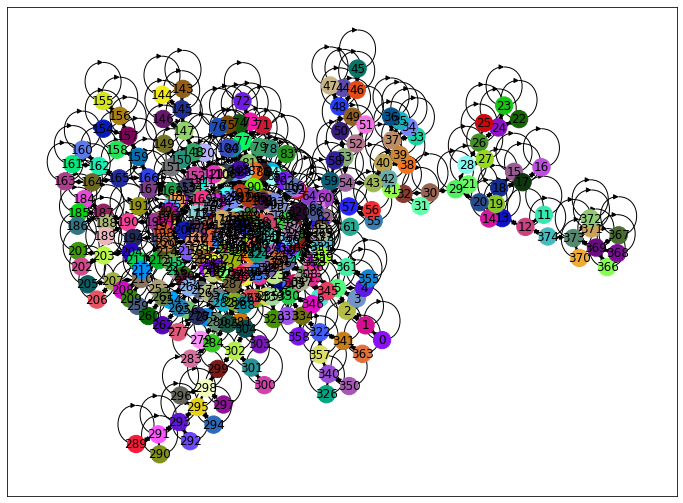

In [12]:
data = val_dataset[4200]
print("# training samples:", len(train_dataset))
print("# validation samples:", len(val_dataset))
print("# vertices:", data.num_nodes)
print("# edges:", data.num_edges)
print("# vertex features:", data.num_node_features)
print("# edge features:", data.num_edge_features)
print("directed graph?:", data.is_directed())
print("isolated vertices?", data.has_isolated_nodes())
print("self-loops?", data.has_self_loops())
print("coalesced?", data.is_coalesced())
print("valid?", data.validate())
plt.figure(figsize=(12, 9))
graph = to_networkx(data, to_undirected=False)
nx.draw_networkx(graph, pos=nx.drawing.kamada_kawai_layout(graph), with_labels=True,
                 node_color=[tuple(torch.rand(3)) for _ in range(375)])

In [13]:
# TODO try F.elu at some point
if False:
    model = MLP(window_size_hrs=HPARAMS["data"]["window_size"], 
                num_hidden=HPARAMS["model"]["propagation_dist"], 
                hidden_size=HPARAMS["model"]["hidden_size"],
                residual=HPARAMS["model"]["residual"])
else:
    edge_weights = get_edge_weights(HPARAMS["model"]["weight_type"], data)
    model = GCN(window_size_hrs=HPARAMS["data"]["window_size"],
                num_convs=HPARAMS["model"]["propagation_dist"],
                hidden_size=HPARAMS["model"]["hidden_size"],
                residual=HPARAMS["model"]["residual"],
                edge_weights=edge_weights)
print(summary(model, depth=2))

history = train(model, train_dataset, val_dataset, HPARAMS, on_ipu=True)

Layer (type:depth-idx)                   Param #
GCN                                      1,123
├─Linear: 1-1                            3,200
├─ModuleList: 1-2                        --
│    └─GCNConv: 2-1                      16,512
│    └─GCNConv: 2-2                      16,512
│    └─GCNConv: 2-3                      16,512
│    └─GCNConv: 2-4                      16,512
│    └─GCNConv: 2-5                      16,512
│    └─GCNConv: 2-6                      16,512
│    └─GCNConv: 2-7                      16,512
│    └─GCNConv: 2-8                      16,512
│    └─GCNConv: 2-9                      16,512
│    └─GCNConv: 2-10                     16,512
│    └─GCNConv: 2-11                     16,512
│    └─GCNConv: 2-12                     16,512
│    └─GCNConv: 2-13                     16,512
│    └─GCNConv: 2-14                     16,512
│    └─GCNConv: 2-15                     16,512
│    └─GCNConv: 2-16                     16,512
│    └─GCNConv: 2-17                     16,5

Graph compilation: 100%|██████████| 100/100 [04:58<00:00]


Training on IPU


Validating: 100%|██████████| 456/456 [00:05<00:00, 86.94it/s, val_loss=0.598]
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1432: UserWarning: Positional args are being deprecated, use kwargs instead. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


[Epoch 1/20] Train: 16596.8920 | Val 0.5975


Validating: 100%|██████████| 456/456 [00:05<00:00, 82.07it/s, val_loss=0.35]  


[Epoch 2/20] Train: 0.4565 | Val 0.3495


Validating: 100%|██████████| 456/456 [00:05<00:00, 88.14it/s, val_loss=0.228] 


[Epoch 3/20] Train: 0.3708 | Val 0.2283


Validating: 100%|██████████| 456/456 [00:05<00:00, 85.12it/s, val_loss=0.219]


[Epoch 4/20] Train: 0.2648 | Val 0.2194


Validating: 100%|██████████| 456/456 [00:05<00:00, 88.89it/s, val_loss=0.122] 


[Epoch 5/20] Train: 0.2049 | Val 0.1221


Validating: 100%|██████████| 456/456 [00:05<00:00, 89.14it/s, val_loss=0.0966]


[Epoch 6/20] Train: 0.1671 | Val 0.0966


Validating: 100%|██████████| 456/456 [00:05<00:00, 83.12it/s, val_loss=0.0863]


[Epoch 7/20] Train: 0.1587 | Val 0.0863


Validating: 100%|██████████| 456/456 [00:05<00:00, 86.58it/s, val_loss=0.0605]


[Epoch 8/20] Train: 0.1334 | Val 0.0605


Validating: 100%|██████████| 456/456 [00:05<00:00, 85.43it/s, val_loss=0.0496]


[Epoch 9/20] Train: 0.1215 | Val 0.0496


Validating: 100%|██████████| 456/456 [00:05<00:00, 83.91it/s, val_loss=0.0425] 


[Epoch 10/20] Train: 0.0956 | Val 0.0425


Validating: 100%|██████████| 456/456 [00:05<00:00, 87.87it/s, val_loss=0.0336] 


[Epoch 11/20] Train: 0.0994 | Val 0.0336


Validating: 100%|██████████| 456/456 [00:05<00:00, 84.86it/s, val_loss=0.0272] 


[Epoch 12/20] Train: 0.0459 | Val 0.0272


Validating: 100%|██████████| 456/456 [00:05<00:00, 83.67it/s, val_loss=0.0258] 


[Epoch 13/20] Train: 0.0469 | Val 0.0258


Validating: 100%|██████████| 456/456 [00:05<00:00, 86.10it/s, val_loss=0.0233] 


[Epoch 14/20] Train: 0.0469 | Val 0.0233


Validating: 100%|██████████| 456/456 [00:05<00:00, 87.92it/s, val_loss=0.0337] 


[Epoch 15/20] Train: 0.0313 | Val 0.0337


Validating: 100%|██████████| 456/456 [00:05<00:00, 82.97it/s, val_loss=0.0201] 


[Epoch 16/20] Train: 0.0247 | Val 0.0201


Validating: 100%|██████████| 456/456 [00:05<00:00, 87.18it/s, val_loss=0.0221] 


[Epoch 17/20] Train: 0.0262 | Val 0.0221


Validating: 100%|██████████| 456/456 [00:05<00:00, 80.03it/s, val_loss=0.0251] 


[Epoch 18/20] Train: 0.0195 | Val 0.0251


Validating: 100%|██████████| 456/456 [00:05<00:00, 85.98it/s, val_loss=0.0234] 


[Epoch 19/20] Train: 0.0197 | Val 0.0234


Validating: 100%|██████████| 456/456 [00:05<00:00, 81.70it/s, val_loss=19.1]   


[Epoch 20/20] Train: 0.0255 | Val 19.1328


0.0247/0.0201


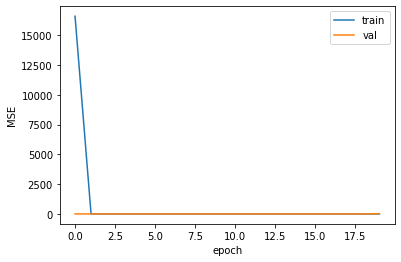

In [14]:
plt.plot(history["train_loss"], label="train")
plt.plot(history["val_loss"], label="val")
plt.xlabel("epoch")
plt.ylabel("MSE")
plt.legend()
i = history["val_loss"].index(min(history["val_loss"]))
print(f"{history['train_loss'][i]:.4f}/{history['val_loss'][i]:.4f}")

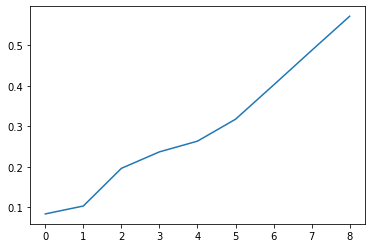

In [29]:
plt.plot([history["model_params"][i]["edge_weights"].std() for i in range(20)])